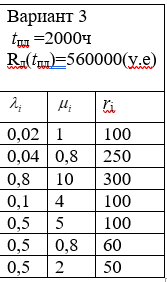
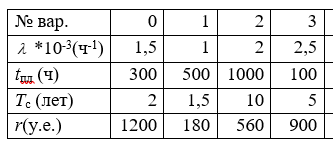
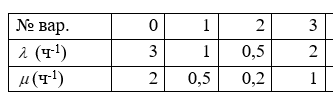

In [1]:
import numpy as np
import pandas as pd
import scipy
import math
from numpy.random import Generator, PCG64
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff


In [2]:
t_plan = 2000
R_d_t_plan = 560000

df1 = pd.DataFrame(data={
    "lambda": [0.2, 0.04, 0.8, 0.1, 0.5, 0.5, 0.5],
    "mu": [1, 0.8, 10, 4, 5, 0.8, 2],
    "risk": [100, 250, 300, 100, 100, 60, 50]
})
df1

,lambda,mu,risk
0,0.20,1.0,100
1,0.04,0.8,250
2,0.80,10.0,300
3,0.10,4.0,100
4,0.50,5.0,100
5,0.50,0.8,60
6,0.50,2.0,50


In [3]:
lambda_2 = 2.5 * 10**(-3)
t_plan2 = 100 # часов
T_mean = 5 # лет
risk_2 = 900 # у.е.

In [4]:
lambda_3 = 2
mu_3 = 1

In [5]:
rng = Generator(PCG64(seed=42))

Text

In [6]:
lambda_mean1 = df1["lambda"].sum()
mu_mean1 = lambda_mean1 / df1[["lambda", "mu"]].apply(lambda x: x[0]/x[1]).sum()

print(f"Интенсивность отказа: {round(lambda_mean1, 5)}")
print(f"Интенсивность восстановления: {round(mu_mean1, 5)}")

Интенсивность отказа: 2.64
Интенсивность восстановления: 0.4224


In [7]:
T1_mean = 1/lambda_mean1
T1_restore = 1/mu_mean1

print(f"Средняя наработка на отказ: {round(T1_mean, 5)}")
print(f"Среднее время восстановления: {round(T1_restore, 5)}")

Средняя наработка на отказ: 0.37879
Среднее время восстановления: 2.36742


In [8]:
K_read = mu_mean1 / (lambda_mean1 + mu_mean1)
K_idle = lambda_mean1 / (lambda_mean1 + mu_mean1)

print(f"Коэффициент готовности {round(K_read,5)}")
print(f"Коэффициент простоя {round(K_idle,5)}")

Коэффициент готовности 0.13793
Коэффициент простоя 0.86207


Графики

In [9]:
def readines_func(lambda_x: float, mu: float, t_max: int):
    times = np.arange(0, t_max, 0.1)
    k_read = mu / (lambda_x + mu)
    p0_t = k_read * (1 + lambda_x/mu * np.exp(-(lambda_x+mu)*times))
    return p0_t, times

In [10]:
readines_mu = readines_func(lambda_mean1, mu_mean1, 3)
px.line(x=readines_mu[1], y=readines_mu[0],
        title='Функция готовности mu_mean', markers=True,
        labels={"x": "t", "y": "p0(t)"}, range_y=[0,1.1], range_x=[-0.1,3.1])

In [11]:
readines_mu = readines_func(lambda_mean1, 0.1 * mu_mean1, 4)
px.line(x=readines_mu[1], y=readines_mu[0],
        title='Функция готовности 0.1mu_mean', markers=True,
        labels={"x": "t", "y": "p0(t)"}, range_y=[0,1.1], range_x=[-0.1,4.1])

In [12]:
readines_mu = readines_func(lambda_mean1, 10 * mu_mean1, 2)
px.line(x=readines_mu[1], y=readines_mu[0],
        title='Функция готовности 10mu_mean', markers=True,
        labels={"x": "t", "y": "p0(t)"}, range_y=[0,1.1], range_x=[-0.1,2.1])

построить графики нижней и верхней оценок риска системы, определить риск за время равное планируемому времени непрерывной работы tпл , сравнить значение риска с допустимым значением Rд(tпл)

In [13]:
risk1_sum = df1[["lambda", "risk"]].apply(lambda x: x[0]*x[1]).sum()

In [14]:
times1_risk = np.arange(0, 20, 1)

In [15]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=times1_risk, y=times1_risk*risk1_sum, mode='lines+markers', name='Верхняя оценка риска'))
fig.add_trace(go.Scatter(x=times1_risk, y=K_read*times1_risk*risk1_sum, mode='lines+markers', name='Нижняя оценка риска'))
fig.update_layout(title="Двусторонние оценки риска",
                  xaxis_title="t", yaxis_title="R(t)",
                  template="plotly_white")
fig.show(width=800)

In [16]:
risk1_high_t_plan = t_plan * risk1_sum
risk1_low_t_plan = t_plan * K_read * risk1_sum
risk1_t_plan = (risk1_high_t_plan + risk1_low_t_plan) / 2
print(f"планируемое время работы: {t_plan}")
print(f"допустимый риск: {R_d_t_plan}")
print(f"Риск за планируемое время работы: {round(risk1_t_plan,5)}")

планируемое время работы: 2000
допустимый риск: 560000
Риск за планируемое время работы: 28448284.96552


2. Исследование надежности и риска восстанавливаемой системы с дублированием

In [17]:
l2mu_coefs_arr = np.array([0.01, 0.1, 1, 10])

In [18]:
def duble_system2_t_work(lambda_:float, l2mu_coef: float, is_load:bool):
    load_coef = 1 if is_load else 0
    t = ((load_coef+2)*lambda_ + (lambda_/l2mu_coef)) / ((load_coef+1)* lambda_**2)
    return t

In [19]:
l2mu_coef = 0.01
t2w_mean_load = duble_system2_t_work(lambda_=lambda_2, l2mu_coef=l2mu_coef, is_load=True)
t2w_mean_unload = duble_system2_t_work(lambda_=lambda_2, l2mu_coef=l2mu_coef, is_load=False)
print(f"коэффициент lambda/mu: {round(l2mu_coef,3)}")
print(f"среднее время безотказной работы нагруженный режим: {round(t2w_mean_load,3)}")
print(f"среднее время безотказной работы не нагруженный режим: {round(t2w_mean_unload,3)}")

коэффициент lambda/mu: 0.01
среднее время безотказной работы нагруженный режим: 20600.0
среднее время безотказной работы не нагруженный режим: 40800.0


In [20]:
l2mu_coef = 0.1
t2w_mean_load = duble_system2_t_work(lambda_=lambda_2, l2mu_coef=l2mu_coef, is_load=True)
t2w_mean_unload = duble_system2_t_work(lambda_=lambda_2, l2mu_coef=l2mu_coef, is_load=False)
print(f"коэффициент lambda/mu: {round(l2mu_coef,3)}")
print(f"среднее время безотказной работы нагруженный режим: {round(t2w_mean_load,3)}")
print(f"среднее время безотказной работы не нагруженный режим: {round(t2w_mean_unload,3)}")

коэффициент lambda/mu: 0.1
среднее время безотказной работы нагруженный режим: 2600.0
среднее время безотказной работы не нагруженный режим: 4800.0


In [21]:
l2mu_coef = 1
t2w_mean_load = duble_system2_t_work(lambda_=lambda_2, l2mu_coef=l2mu_coef, is_load=True)
t2w_mean_unload = duble_system2_t_work(lambda_=lambda_2, l2mu_coef=l2mu_coef, is_load=False)
print(f"коэффициент lambda/mu: {round(l2mu_coef,3)}")
print(f"среднее время безотказной работы нагруженный режим: {round(t2w_mean_load,3)}")
print(f"среднее время безотказной работы не нагруженный режим: {round(t2w_mean_unload,3)}")

коэффициент lambda/mu: 1
среднее время безотказной работы нагруженный режим: 800.0
среднее время безотказной работы не нагруженный режим: 1200.0


In [22]:
l2mu_coef = 10
t2w_mean_load = duble_system2_t_work(lambda_=lambda_2, l2mu_coef=l2mu_coef, is_load=True)
t2w_mean_unload = duble_system2_t_work(lambda_=lambda_2, l2mu_coef=l2mu_coef, is_load=False)
print(f"коэффициент lambda/mu: {round(l2mu_coef,3)}")
print(f"среднее время безотказной работы нагруженный режим: {round(t2w_mean_load,3)}")
print(f"среднее время безотказной работы не нагруженный режим: {round(t2w_mean_unload,3)}")

коэффициент lambda/mu: 10
среднее время безотказной работы нагруженный режим: 620.0
среднее время безотказной работы не нагруженный режим: 840.0


In [23]:
def benefit_duble_system2(lambda_: float, l2mu_coef: float, is_load:bool):
    T0 = 0.0
    if is_load:
        T0 = 3/(2*lambda_)
    else:
        T0 = 2/lambda_
    T1 = duble_system2_t_work(lambda_=lambda_, l2mu_coef=l2mu_coef, is_load=is_load)
    z = T1/T0
    return z

In [24]:
benefit_duble_system2_loaded = np.array(
    [benefit_duble_system2(lambda_=lambda_2, l2mu_coef=l2mu_coef, is_load=True) for l2mu_coef in l2mu_coefs_arr]
)
benefit_duble_system2_unloaded = np.array(
    [benefit_duble_system2(lambda_=lambda_2, l2mu_coef=l2mu_coef, is_load=False) for l2mu_coef in l2mu_coefs_arr]
)

benefit_duble_system2_df = pd.DataFrame(data={
    "l2mu_coef": l2mu_coefs_arr,
    "benefit_loaded": benefit_duble_system2_loaded,
    "benefit_unloaded": benefit_duble_system2_unloaded,
})
benefit_duble_system2_df

,l2mu_coef,benefit_loaded,benefit_unloaded
0,0.01,34.333333,51.00
1,0.10,4.333333,6.00
2,1.00,1.333333,1.50
3,10.00,1.033333,1.05


In [25]:
# Гистограмма плотностей относительных частот разных распределений
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=benefit_duble_system2_df['l2mu_coef'],
           y=benefit_duble_system2_df["benefit_loaded"],
           opacity=0.9, name='Нагруженный резерв',
           marker=dict(color='blue'),
           legendgroup = "1", showlegend=True
          )
)
fig.add_trace(
    go.Scatter(x=benefit_duble_system2_df['l2mu_coef'],
           y=benefit_duble_system2_df["benefit_unloaded"],
           opacity=0.9, name='Ненагруженный резерв',
           marker=dict(color='red'),
           legendgroup = "2", showlegend=True,
          )
)
fig.update_layout(
    title="график выигрыша в среднем времени безотказной работы за счет восстановления при нагруженном и ненагруженном резервах",
    xaxis_title="Коэффициент (lambda/mu) (LOG)",
    yaxis_title="Выигрыш (z)",
    template="plotly_white",
    yaxis_range=[-5, 55],
    xaxis_type='log',  # логарифмическая шкала по оси X
)
fig.show()

выполнить моделирование системы для случая μ=2λ
, получить оценку среднего времени безотказной работы.

In [26]:
# Заданные параметры
n = 10000  # количество отказов, которые нужно смоделировать
S = 0      # суммарная наработка
k = 0      # количество отказов
rng = Generator(PCG64(seed=8)) # генератор случайных чисел
mu2_test = 2 * lambda_2

def get_ksi():
    # генерация времени безотказной работы элемента
    return rng.exponential(scale=1/lambda_2)
    # return -np.log(rng.uniform(0,1)) / lambda_2

def get_eta():
    # генерация времени восстановления
    return rng.exponential(scale=1/mu2_test)
    # return -np.log(rng.uniform(0,1)) / mu2_test


while k < n: # цикл на n экспериментов
    ksi0 = get_ksi()
    S += ksi0
    i = 1
    j = 0

    is_start: bool = True
    
    while True:
        ksi_i = get_ksi() # получаем время работы элемента
        S += ksi_i

        # если система только запущена, то резерв не в восстановлении
        if is_start:
            eta_j = 0
            is_start = False
        else:
            eta_j = get_eta() # время, которое будет восстанавливаеться резерв
        

        if ksi_i >= eta_j: # успел ли восстановиться резерв
            # да
            continue
        else:
            k += 1
            break

# Расчёт средней наработки на отказ
T_mean_model2 = S / n
print(f"Средняя наработка на отказ T = {T_mean_model2:.4f}")
print(f"Средняя наработка на отказ T (года) = {T_mean_model2/8760:.4f}")

Средняя наработка на отказ T = 2002.0210
Средняя наработка на отказ T (года) = 0.2285


2.2 Система многократного использования

In [27]:
def readines_coef_repair2(gamma_coef: float, is_load: bool, k: int = 1):
    load_coef = int(is_load) + 1
    return (1+load_coef*gamma_coef) / (1 + load_coef*gamma_coef + 1/k * load_coef * gamma_coef**2)

In [28]:
repair_k1_readines_system2_loaded = np.array(
    [readines_coef_repair2(gamma_coef=l2mu_coef, is_load=True) for l2mu_coef in l2mu_coefs_arr]
)
repair_k1_readines_system2_unloaded = np.array(
    [readines_coef_repair2(gamma_coef=l2mu_coef, is_load=False) for l2mu_coef in l2mu_coefs_arr]
)
repair_k2_readines_system2_loaded = np.array(
    [readines_coef_repair2(gamma_coef=l2mu_coef, is_load=True, k=2) for l2mu_coef in l2mu_coefs_arr]
)
repair_k2_readines_system2_unloaded = np.array(
    [readines_coef_repair2(gamma_coef=l2mu_coef, is_load=False, k=2) for l2mu_coef in l2mu_coefs_arr]
)

repair_readines_system2_df = pd.DataFrame(data={
    "l2mu_coef": l2mu_coefs_arr,
    "readines_k1_loaded": repair_k1_readines_system2_loaded,
    "readines_k1_unloaded": repair_k1_readines_system2_unloaded,
    "readines_k2_loaded": repair_k2_readines_system2_loaded,
    "readines_k2_unloaded": repair_k2_readines_system2_unloaded,
})

repair_readines_system2_df

,l2mu_coef,readines_k1_loaded,readines_k1_unloaded,readines_k2_loaded,readines_k2_unloaded
0,0.01,0.999804,0.999901,0.999902,0.999950
1,0.10,0.983607,0.990991,0.991736,0.995475
2,1.00,0.600000,0.666667,0.750000,0.800000
3,10.00,0.095023,0.099099,0.173554,0.180328


In [29]:
# Гистограмма плотностей относительных частот разных распределений
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=repair_readines_system2_df['l2mu_coef'],
           y=repair_readines_system2_df["readines_k1_loaded"], name='Нагруженный резерв (k=1)',
          )
)
fig.add_trace(
    go.Scatter(x=repair_readines_system2_df['l2mu_coef'],
           y=repair_readines_system2_df["readines_k1_unloaded"], name='Ненагруженный резерв (k=1)',
          )
)
fig.add_trace(
    go.Scatter(x=repair_readines_system2_df['l2mu_coef'],
           y=repair_readines_system2_df["readines_k2_loaded"], name='Нагруженный резерв (k=2)',
          )
)
fig.add_trace(
    go.Scatter(x=repair_readines_system2_df['l2mu_coef'],
           y=repair_readines_system2_df["readines_k2_unloaded"], name='Ненагруженный резерв (k=2)',
          )
)
fig.update_layout(
    title="График коэффициента готовности по разным системам",
    xaxis_title="Коэффициент (lambda/mu) (LOG)",
    yaxis_title="Готовность",
    template="plotly_white",
    yaxis_range=[-0.2, 1.2],
    xaxis_type='log',  # логарифмическая шкала по оси X
)
fig.show()

In [30]:
rng = Generator(PCG64(seed=8)) # генератор случайных чисел

l2mu_coefs_series = pd.Series(rng.uniform(low=0.01, high=10, size=100)).sort_values(ignore_index=True)
# Гистограмма плотностей относительных частот разных распределений
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=l2mu_coefs_series,
           y=l2mu_coefs_series.apply(readines_coef_repair2, is_load=True), name='Нагруженный резерв (k=1)',
          )
)
fig.add_trace(
    go.Scatter(x=l2mu_coefs_series,
           y=l2mu_coefs_series.apply(readines_coef_repair2, is_load=False), name='Ненагруженный резерв (k=1)',
          )
)
fig.add_trace(
    go.Scatter(x=l2mu_coefs_series,
           y=l2mu_coefs_series.apply(readines_coef_repair2, is_load=True, k=2), name='Нагруженный резерв (k=2)',
          )
)
fig.add_trace(
    go.Scatter(x=l2mu_coefs_series,
           y=l2mu_coefs_series.apply(readines_coef_repair2, is_load=False, k=2), name='Ненагруженный резерв (k=2)',
          )
)
fig.update_layout(
    title="График коэффициента готовности по разным системам",
    xaxis_title="Коэффициент (lambda/mu)",
    yaxis_title="Готовность",
    template="plotly_white",
    yaxis_range=[-0.2, 1.2],
    xaxis_range=[0, 10.1]
    # xaxis_type='log',  # логарифмическая шкала по оси X
)
fig.show()

In [31]:
def t_mean_repair2(lambda_: float, gamma_coef: float, is_load: bool):
    load_coef = int(is_load) +1
    T0 = 1/ lambda_
    return T0 * (1+1/(load_coef * gamma_coef))

In [32]:
mean_fail_time_system2_loaded = np.array(
    [t_mean_repair2(lambda_ = lambda_2, gamma_coef=l2mu_coef, is_load=True) for l2mu_coef in l2mu_coefs_arr]
)
mean_fail_time_system2_unloaded = np.array(
    [t_mean_repair2(lambda_ = lambda_2, gamma_coef=l2mu_coef, is_load=False) for l2mu_coef in l2mu_coefs_arr]
)

mean_fail_time_system2_df = pd.DataFrame(data={
    "l2mu_coef": l2mu_coefs_arr,
    "mean_T_loaded": mean_fail_time_system2_loaded,
    "mean_T_unloaded": mean_fail_time_system2_unloaded,
})

mean_fail_time_system2_df

,l2mu_coef,mean_T_loaded,mean_T_unloaded
0,0.01,20400.0,40400.0
1,0.10,2400.0,4400.0
2,1.00,600.0,800.0
3,10.00,420.0,440.0


3. Исследование надежности информационной восстанавливаемой системы

In [33]:
def readines_multiple(chanels: int, gamma_coef: float):
    chan_array = np.arange(0, chanels+1, 1)
    stepeni = gamma_coef ** chan_array
    factorials = scipy.special.factorial(chan_array)
    chan_array_presum =  stepeni / factorials
    summ = np.sum(chan_array_presum)
    det = scipy.special.factorial(chanels) * summ
    K_read = 1 - gamma_coef ** chanels / det
    return K_read

In [34]:
l2mu_coef31 = 1
chanels_series = pd.Series(np.arange(0, 10, 1))
# Гистограмма плотностей относительных частот разных распределений
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=chanels_series,
           y=chanels_series.apply(readines_multiple, gamma_coef=1), name='Коэффициент готовности',
          )
)
fig.update_layout(
    title="График коэффициента готовности от количества каналов gamma = 1",
    xaxis_title="Количество каналов",
    yaxis_title="Коэффициент готовности",
    template="plotly_white",
    xaxis=dict(
        dtick=1  # шаг по оси X
    ),
    yaxis=dict(
        dtick=0.1  # шаг по оси Y
    ),
)
fig.show()

In [35]:
l2mu_coef31 = 1
chanels_series = pd.Series(np.arange(0, 10, 1))
# Гистограмма плотностей относительных частот разных распределений
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=chanels_series,
           y=chanels_series.apply(readines_multiple, gamma_coef=lambda_3/mu_3), name='Коэффициент готовности',
          )
)
fig.add_shape(
    type="line",
    x0=0, x1=1,  # координаты по x в относительных единицах (от 0 до 1 по ширине графика)
    y0=0.9, y1=0.9,
    xref='paper',  # означает, что x0 и x1 даны в долях ширины области построения
    yref='y',      # y0 и y1 в координатах оси Y
    line=dict(color="red", width=2, dash="dash")
)
fig.update_layout(
    title="График коэффициента готовности",
    xaxis_title="Количество каналов",
    yaxis_title="Коэффициент готовности",
    template="plotly_white",
    xaxis=dict(
        dtick=1  # шаг по оси X
    ),
    yaxis=dict(
        dtick=0.1  # шаг по оси Y
    ),
)
fig.show()